<img src="https://raw.githubusercontent.com/GeoscienceAustralia/dea-notebooks/stable/Supplementary_data/dea_logo_wide.jpg" 
     alt="DEA Notebooks logo" 
     style="width:80%;">


# Exploring Sentinel-2A and -2B imagery

🔎 Visit [DEA's Knowledge Hub](https://knowledge.dea.ga.gov.au/) for detailed technical information about the datasets and concepts used in this notebook.

<div style="
    border-left: 6px solid var(--jp-success-color1, #4CAF50);
    background-color: rgba(76, 175, 80, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>🚀 How you can run this notebook</b><br><br>
- <b>DEA Sandbox:</b> Eligible users can sign up for the 
<a href="https://sandbox.dea.ga.gov.au/" target="_blank">DEA Sandbox</a> 
that provides free compute and a managed Python environment.<br><br>
- <b>Personal computer:</b> This notebook loads DEA data using <code>odc-stac</code>. 
Data streams via the internet, so can be run locally after installing the required 
<a href="https://pypi.org/project/dea-tools/" target="_blank">DEA Tools</a> Python package, 
e.g. <code>pip install dea-tools[notebooks]</code>.
</div>

<div style="
    border-left: 6px solid var(--jp-info-color1, #2196F3);
    background-color: rgba(33, 150, 243, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>📦 Products used:</b><br>
<a href="https://explorer.dea.ga.gov.au/ga_s2am_ard_3" target="_blank">ga_s2am_ard_3</a> and
<a href="https://explorer.dea.ga.gov.au/ga_s2bm_ard_3" target="_blank">ga_s2bm_ard_3</a>
</div>



## Description
This notebook demonstrates how to access and view Sentinel-2 A and B optical data within Digital Earth Australia (DEA; https://www.ga.gov.au/scientific-topics/dea) and through the Open Data Cube (www.opendata.org).  Also, consult the DEA Knowledge Hub (https://knowledge.dea.ga.gov.au/guides/setup/dea_maps/)

Topics covered in this notebook include:

1. Choosing an area of interest (we have chosen Hinchinbrook Island in Queensland and Sydney in New South Wales Australia but you can select either area or another).
2. Loading Sentinel 2A or 2B optical data for the selected area and reviewing the different wavebands of the Sentinel-2A and -2B sensors.
3. Displaying the Sentinel 2A or 2B images in various band combinations and exploring images over time.
4. Calculating and displaying a simple index, in this case the Normalised Difference Vegetation Index (NDVI), from the image data.
5. Exporting the data as a Geotiff for further analysis (e.g., within ARCGIS or QGIS).

***

## Sentinel-2A and -2B
The Sentinel-2A and -2B Multi-Spectral Instruments (MSI) were launched by the European Space Agency (ESA; https://www.esa.int/).  Each Sentinel MSI records energy in 13 spectral bands, with four being at 10 m spatial resolution,six at 20 m and three at 60 m.  When these two sensors were in orbit at the same time, the revisit frequency at the Equator was nominally 5 days but decreased to 10 days when only one was in operation.  

More information on these sensors can be found at https://database.eohandbook.com/database/missionsummary.aspx?missionID=552&utm_source=eoportal&utm_content=copernicus-sentinel-2.

## Getting started
Run each cell in the notebook sequentially, starting with the "Load packages" cell (below). For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Jupyter_notebooks.ipynb) in the Beginners Guide folder. However, some guidance is given below.

## A note on Jupyter notebooks
### Running (executing) a cell
Jupyter Notebooks allow code to be separated into sections that can be executed independent of one another.
These sections are called "cells".

Python code is written into individual cells that can be executed by placing the cursor in the cell and typing `Shift-Enter` on the keyboard or selecting the &#9658; "Run the selected cells and advance" button in the ribbon at the top of the notebook.
These options will run a single cell at a time.

To automatically run all cells in a notebook, navigate to the "Run" tab of the menu bar at the top of JupyterLab and select "Run All Cells" (or the option that best suits your needs).
When a cell is run, the cell's content is executed.
Any output produced from running the cell will appear directly below it.

### Cell status

The `[ ]:` symbol to the left of each Code cell describes the state of the cell:

* `[ ]:` means that the cell has not been run yet.
* `[*]:` means that the cell is currently running.
* `[1]:` means that the cell has finished running and was the first cell run.

The number indicates the order that the cells were run in.

> **Note:** To check whether a cell is currently executing in a Jupyter notebook, inspect the small circle in the top-right of the window. 
The circle will turn grey ("Kernel busy") when the cell is running, and return to empty ("Kernel idle") when the process is complete.

### Load packages
The cell below imports Python packages that are used for the analysis.
The first command is `%matplotlib inline`, which ensures figures plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `dea_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

In [1]:
%matplotlib inline

import sys
import pystac_client
import odc.stac

from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

import matplotlib.pyplot as plt

from dea_tools.plotting import display_map, rgb

## Connect to DEA's STAC API
This allows us to search for data using DEA's STAC API (refer to the SpatioTemporal Asset Catalogue guide for details).

To load data, we must also configure access to DEA's Amazon S3 buckets using `odc.stac.configure_s3_access`. If launching a Dask client with `dea_tools.dask.create_local_dask_cluster()`, this is done automatically.

In [2]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

## Step 1: Choose a study area

When working with the Open Data Cube, it's important to load only as much data as needed.
This helps keep an analysis running quickly and avoids the notebook crashing due to insufficient memory.

One way to set the study area is to set a central latitude and longitude coordinate pair, `(central_lat, central_lon)`, then specify how many degrees to include either side of the central latitude and longitude, known as the `buffer`.
Together, these parameters specify a square study area

### Location
Below, we have set the study area covering Hinchinbrook, Queensland, although you can select any area in Australia.
To load a different area, you can provide your own `central_lat` and `central_lon` values.
One way to source these is to Google a location, or click directly on the map in [Google Maps](https://www.google.com/maps/@-43.4539764,146.5660989,11642m/data=!3m1!1e3).

* **Hinchinbrook Island, Queensland, Australia**
```
central_lat = -18.3711
central_lon = 146.1693
```

* **Sydney, New South Wales, Australia**
```
central_lat = -33.8219
central_lon = 151.1108
```
> **Note**: If you change the study area latitude and longitude, you'll need to re-run all of the cells after to apply that change to the whole analysis.

### Buffer
Feel free to experiment with the `buffer` value to load different sized areas.
We recommend that you keep the `buffer` relatively small, no higher than **`buffer=0.1`** degrees.
This will help keep the loading times reasonable and prevent the notebook from crashing.

> **Extension**: Can you modify the code to use a different `buffer` value for latitude and longitude? 

> *Hint*: You may want two variables, `buffer_lat` and `buffer_lon` that you can set independently. You'll then need to update the definitions of `study_area_lat` and `study_area_lon` with their corresponding buffer value.

In [3]:
# Set the central latitude and longitude
#Hinchinbrook Island, Queensland, Australia
central_lat = -18.3711
central_lon = 146.1693

#Sydney, New South Wales, Australia
#central_lat = -33.90
#central_lon = 151.23

# Set the buffer to load around the central coordinates
buffer = 0.09

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

After choosing the study area, it can be useful to visualise it on an interactive map.
This provides a sense of scale.
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

In [4]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Loading Sentinel-2 data

The code below sets up the required information to load the data from either Sentinel-2A (ga_s2am_ard_3) or Sentinel-2B (ga_s2bm_ard_3) in an Anaysis Ready Data (ARD) format - i.e., fully corrected for geometry, biodirectional reflectance and topographic illumination (termed NBART; https://knowledge.dea.ga.gov.au/data/product/dea-surface-reflectance-nbart-sentinel-2a-msi/). Chose the sensor of choice by commenting or uncommenting (removing the # from 's2am' or 's2bm' so only one is run). Note you will be viewing a different set of images as these are  acquired by different sensors but with the same configuration.

In [5]:
# Set the data source - s2a corresponds to Sentinel-2A but you can select Sentinel-2B by changing "a" to "b" and *vice versa*
# note the time-periods below.  

#product = "ga_s2am_ard_3"
product = "ga_s2bm_ard_3"

# If you want to use Sentinel-2b set_product = "ga_s2bm_ard_3"

# Set the date range to load data over
time = ("2022-06-01", "2022-09-01")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue, near-infrared and swir bands
measurements = [
    "nbart_red",
    "nbart_blue",
    "nbart_green",
    "nbart_nir_1",
    "nbart_swir_2"
]

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
crs = "epsg:3577"
resolution = 10

Now we can use the `pystac_client` Python package to search for STAC items that match our query. To do this, we need to set up a `bbox` from our lat/lon/buffer parameters we set above. 

In [6]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time
    )

items = list(query.items()) #convert to list

#now load the data with odc-stac
ds = odc.stac.load(
    items, #stac items
    bands=measurements, #bands of data to load
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox, #area to load over
)

Following the load step, printing the `ds` `xarray.Dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

There's a lot of information to unpack, which is represented by the following aspects of the data:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube, including time.
- `Data variables`: the observations loaded, typically different spectral bands from a satellite
- `Attributes`: additional useful information about the data, such as the `crs` (coordinate reference system)

## Step 3: Plotting data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

Use the `rgb()` function to plot the data loaded in the previous step.
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.
There are several parameters you can experiment with:

* `time_step=n`\
This sets the time step you want to view. 
`n` can be any number from `0` to one fewer than the number of time steps you loaded. 
The number of time steps loaded is given in the print-out of the data, under the `Dimensions` heading. 
As an example, if under `Dimensions:` you see `time: 6`, then there are 6 time steps, and `time_step` can be any number between `0` and `5`.

* `bands = [red_channel, green_channel, blue_channel]`\
This sets the measurements that you want to use to make the image.
Any measurements can be mapped to the three channels, and different combinations highlight different features.
Two common combinations are
    * true colour: 
    `bands = ["nbart_red", "nbart_green", "nbart_blue"]`
    * false colour 1: `bands = ["nbart_nir_1", "nbart_red", "nbart_green"]`
    * false colour 2: 'bands = ["nbart_nir_1", "nbart_swir_2", "nbart_red"]
    
For more detail about customising plots, see the [Introduction to plotting](05_Plotting.ipynb) notebook.  
Experiment with the different combinations of bands.

> **Extension**: If `time_step` is set to an array of values, e.g. `time_step=[time_1, time_2]`, it will plot all provided time steps.
See if you can modify the code to plot the first and last images.
If you do, what changes do you notice?

> *Hint*: To get the last image, you can use a time step value of `-1`

Plotting ...
(Please wait until images appear. This may take a few seconds to minutes depending on your period of interest.)


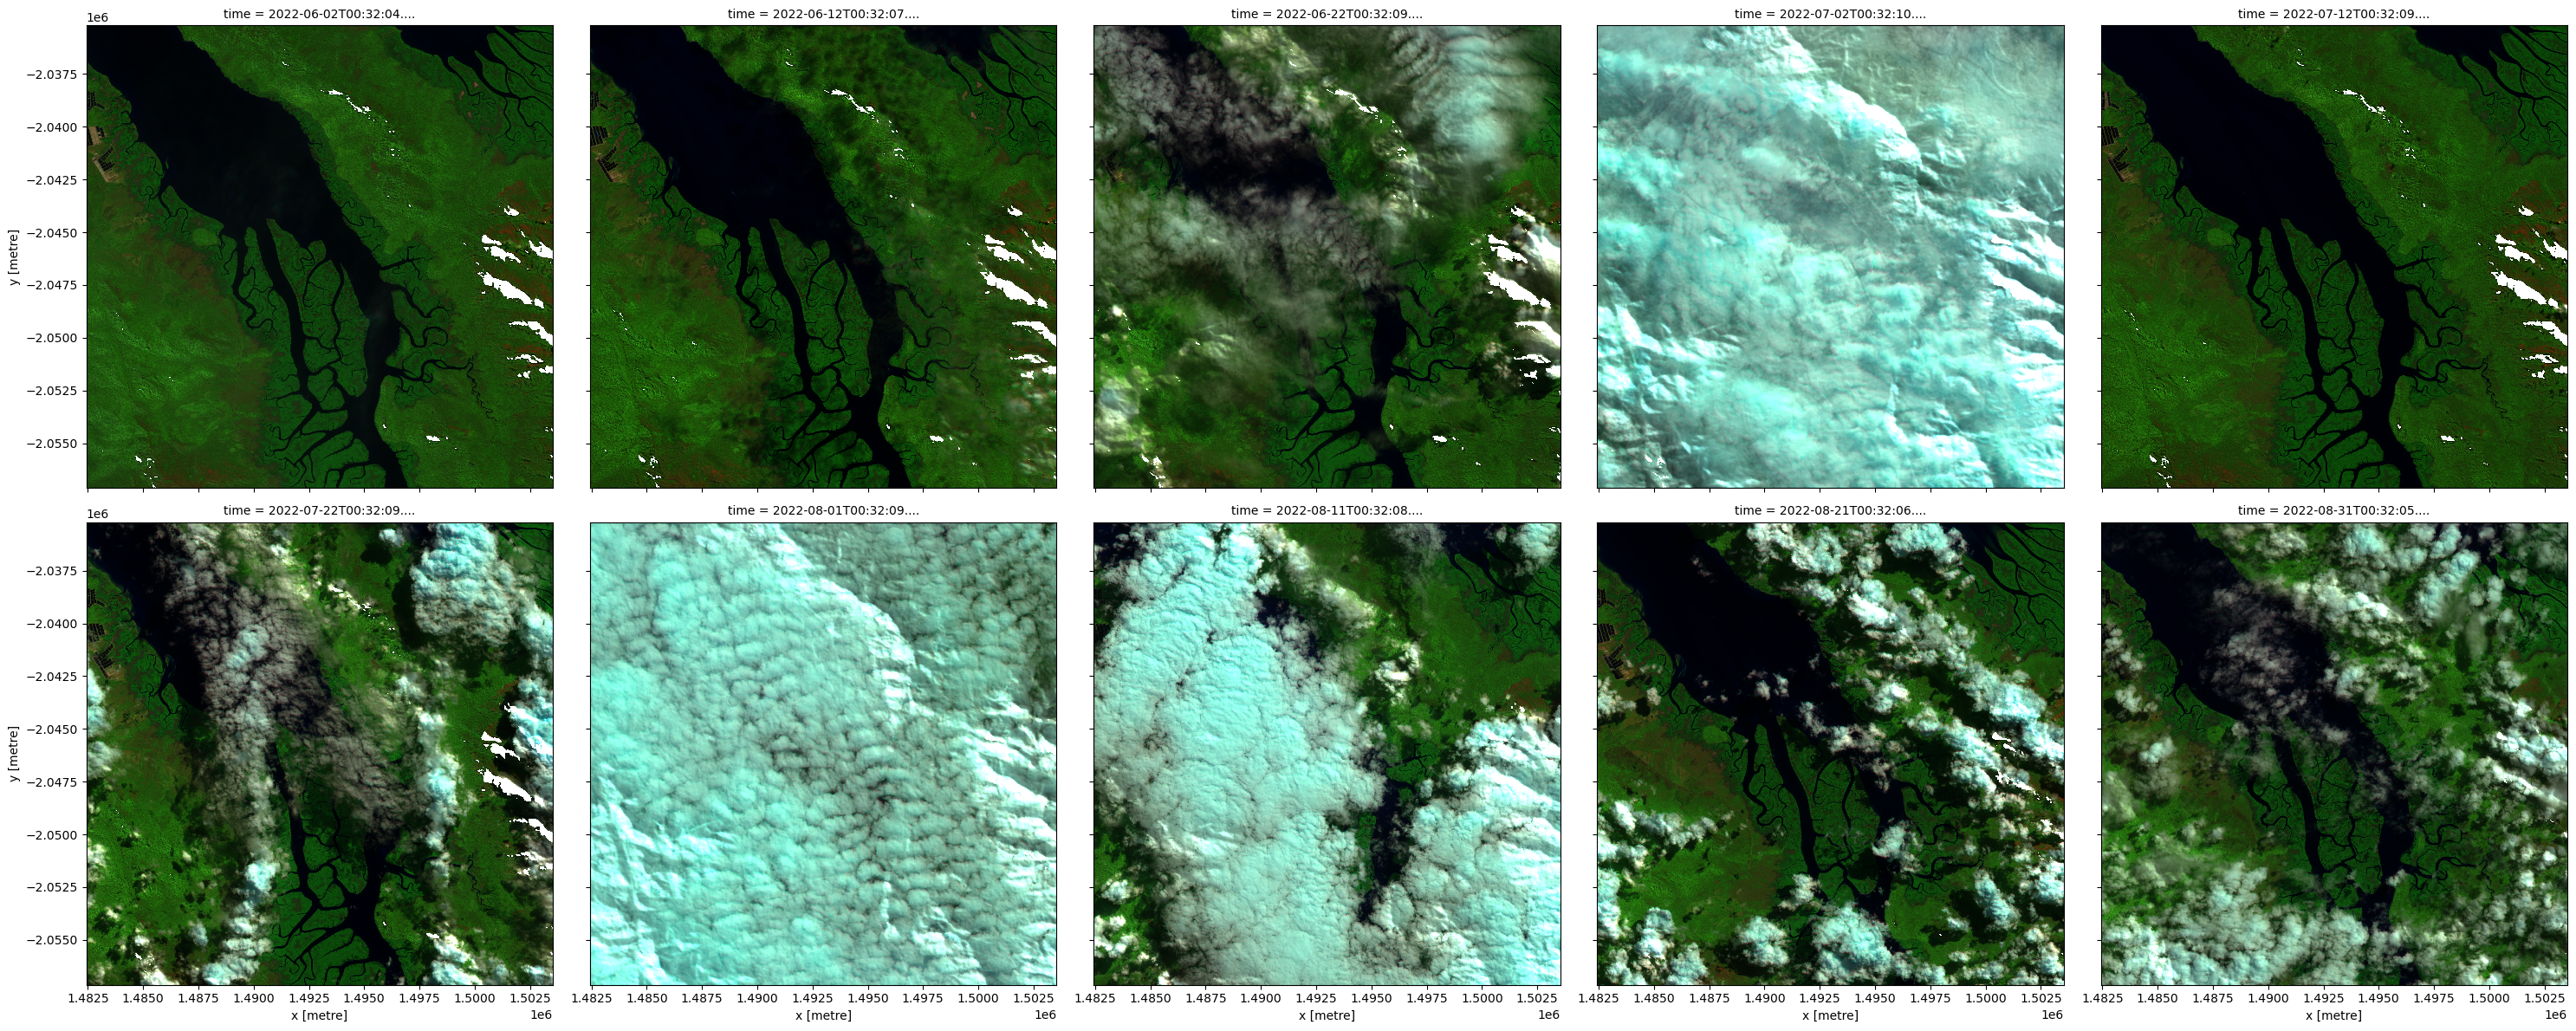

In [7]:
print("Plotting ...")
print("(Please wait until images appear. This may take a few seconds to minutes depending on your period of interest.)")

rgb(ds, bands=["nbart_swir_2", "nbart_nir_1", "nbart_green"], col="time", robust=True, col_wrap=5)

### View specific time steps
* `time_step=n`\
This sets the time step you want to view. 
`n` can be any number from `0` to one fewer than the number of time steps you loaded. 
The number of time steps loaded is given in the print-out of the data, under the `Dimensions` heading. 
As an example, if under `Dimensions:` you see `time: 6`, then there are 6 time steps, and `time_step` can be any number between `0` and `5`.

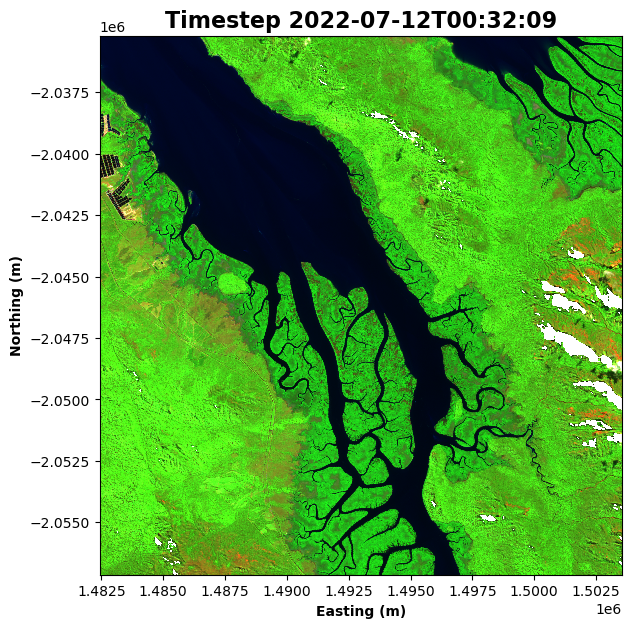

In [8]:
# Set the time step to view (note that 0 is the first image, 1 the second and so on (refer to image above).  -1 is the last image and so on.  You can also try, for example, time_step[4,-1].  
time_step = [4]

# Set the band combination to plot (this is a false-colour image)
bands = ["nbart_swir_2", "nbart_nir_1", "nbart_green"]

# Generate the image by running the rgb function
rgb(ds, bands=bands, index=time_step, size=7)

# Format the time stamp for use as the plot title
time_string = str(ds.time.isel(time=time_step).values[0]).split('.')[0]  

# Set the title and axis labels
ax = plt.gca()
ax.set_title(f"Timestep {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold');


## Step 4: Calculate a spectral index

A wide range of spectral indices are available (see https://www.nv5geospatialsoftware.com/docs/AlphabeticalListSpectralIndices.html) that give more specific information on the environment (e.g., in terms of vegetation health, water quality etc.). However, make note of the specific wavelength regions used as only a selection are relevant to Sentinel-2 data (see https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/).  

In this case, and from the Sentinel-2 data, we will calculate the [Normalised Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) which is an indicator of vegetation health. The formula is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})}, \\
\end{aligned}
$$

where $\text{NIR}$ is the near-infrared band of the data, and $\text{Red}$ is the red band.
NDVI values range from -1 to 1, with negative values indicating non-vegetation (such as water) and high values suggesting healthy vegetation (e.g., with a high amount of photosynthetic pigments). 

The following code calculates the top and bottom of the fraction separately, then computes the NDVI value directly from these components.
The calculated NDVI values are stored as their own data array.

In [9]:
# Calculate the components that make up the NDVI calculation
#
#band_diff = ds.nbart_nir_1 - ds.nbart_red
#band_sum = ds.nbart_nir_1 + ds.nbart_red

band_diff = ds.nbart_nir_1 - ds.nbart_red
band_sum = ds.nbart_nir_1 + ds.nbart_red

# Calculate NDVI and store it as a measurement in the original dataset
ndvi = band_diff / band_sum

After calculating the NDVI values, it is possible to plot them by adding the `.plot()` method to `ndvi` (the variable that the values are stored in).
The code below will plot a single image, based on the time selected with the `ndvi_time_step` variable.
Try changing this value to plot the NDVI map at different time steps.
Do you notice any differences?

> **Extension 1**: Sometimes, it is valuable to change the colour scale to something that helps with intuitively understanding the image.
For example, the "viridis" colour map shows high values in greens/yellows (mapping to vegetation), and low values in blue (mapping to water).
Try modifying the `.plot(cmap="RdYlGn")` command below to use `cmap="viridis"` instead.

> **Extension 2**: Below, a single time step is selected using the `.isel()` method.
It is possible to plot all time steps by removing the `.isel()` method, and modifying the `.plot()` method to be `.plot(col="time", col_wrap=3)`.
Plotting all of the time steps at once may make it easier to notice differences in vegetation over time.

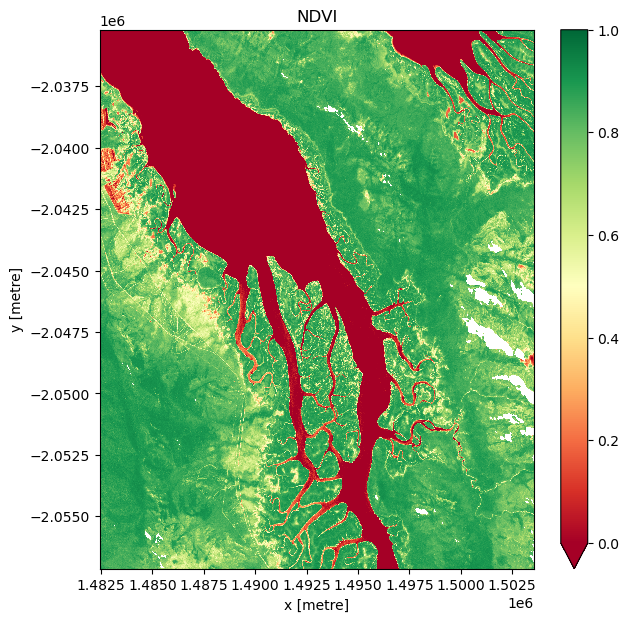

In [10]:
# Set the NDVI time step to view (see above for the reference time)
ndvi_time_step = [4]

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(7, 7))
ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn", vmin=0, vmax=1)
plt.title('NDVI');

## Step 5: Exporting data

Sometimes, you will want to analyse satellite imagery in a GIS program, such as QGIS or ARCGIS PRO.
The `write_cog()` command from the Open Data Cube library allows loaded data to be exported to GeoTIFF, a commonly used file format for geospatial data.
> **Note**: the saved file will appear in the same directory as this notebook, and it can be downloaded from here for later use.

In [11]:
# Export to a file and name accordingly. Try to standardize and so you can record the date 
#filename = "Hinchinbrook Island Selected Date NDVI.tiff"
filename = "Site_Name_Selected_Date_NDVI.tiff"

write_cog(geo_im=ndvi.isel(time=time_step), fname=filename, overwrite=True);

## Recommended next steps

### For this notebook
Many of the variables used in this analysis are configurable.
We recommend returning to the beginning of the notebook and re-running the analysis with a different location, dates, measurements, and so on.
This will help give you more understanding for running your own analysis.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Last modified:** September 2025